In [20]:
import pandas as pd
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
from statsmodels.graphics import utils
import statsmodels.api as sm
from scipy import stats
from matplotlib import font_manager

from reload_recursive import reload_recursive

import mri_data

In [21]:
reload_recursive(mri_data)
from mri_data import utils as mri_utils

In [22]:
# import re

# font_files = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

# for font in font_files:
#     if re.search(r"\.local", font):
#         print(font)
#         font_manager.fontManager.addfont(font)

# plt.rcParams['font.family'] = 'DejaVu Sans'

In [23]:
analysis_dir = Path("/home/srs-9/Projects/ms_mri/analysis")
df_t1 = pd.read_csv(analysis_dir / "choroid_pineal2_pituitary_crosstrain_t1" / "dataframe.csv")
df_t1_2 = pd.read_csv(analysis_dir / "choroid_pineal_pituitary_crosstrain_t1" / "dataframe.csv")
df_t1.rename(columns={"subid": "subject_id"}, inplace=True)
df_flair = pd.read_csv(analysis_dir / "choroid_pineal_pituitary_crosstrain_flair" / "dataframe.csv")
df_t1_flair = pd.read_csv(analysis_dir / "choroid_pineal_pituitary_crosstrain" / "dataframe.csv")

curr_dir = analysis_dir / "paper1"

### Mean Difference Plot Function

Adapted from statsmodels.graphics.agreement

In [24]:
# adapted from statsmodels.graphics.agreement
def mean_diff_plot(m1, m2, sd_limit=1.96, ax=None, scatter_kwds=None,
                   mean_line_kwds=None, limit_lines_kwds=None, ylabels=True,
                   markercolor=[.2, .2, .2]):
    """
    Construct a Tukey/Bland-Altman Mean Difference Plot.

    Tukey's Mean Difference Plot (also known as a Bland-Altman plot) is a
    graphical method to analyze the differences between two methods of
    measurement. The mean of the measures is plotted against their difference.

    For more information see
    https://en.wikipedia.org/wiki/Bland-Altman_plot

    Parameters
    ----------
    m1 : array_like
        A 1-d array.
    m2 : array_like
        A 1-d array.
    sd_limit : float
        The limit of agreements expressed in terms of the standard deviation of
        the differences. If `md` is the mean of the differences, and `sd` is
        the standard deviation of those differences, then the limits of
        agreement that will be plotted are md +/- sd_limit * sd.
        The default of 1.96 will produce 95% confidence intervals for the means
        of the differences. If sd_limit = 0, no limits will be plotted, and
        the ylimit of the plot defaults to 3 standard deviations on either
        side of the mean.
    ax : AxesSubplot
        If `ax` is None, then a figure is created. If an axis instance is
        given, the mean difference plot is drawn on the axis.
    scatter_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.scatter plotting method
    mean_line_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method
    limit_lines_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method

    Returns
    -------
    Figure
        If `ax` is None, the created figure.  Otherwise the figure to which
        `ax` is connected.

    References
    ----------
    Bland JM, Altman DG (1986). "Statistical methods for assessing agreement
    between two methods of clinical measurement"

    Examples
    --------

    Load relevant libraries.

    >>> import statsmodels.api as sm
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt

    Making a mean difference plot.

    >>> # Seed the random number generator.
    >>> # This ensures that the results below are reproducible.
    >>> np.random.seed(9999)
    >>> m1 = np.random.random(20)
    >>> m2 = np.random.random(20)
    >>> f, ax = plt.subplots(1, figsize = (8,5))
    >>> sm.graphics.mean_diff_plot(m1, m2, ax = ax)
    >>> plt.show()

    .. plot:: plots/graphics-mean_diff_plot.py
    """
    fig, ax = utils.create_mpl_ax(ax)

    if len(m1) != len(m2):
        raise ValueError('m1 does not have the same length as m2.')
    if sd_limit < 0:
        raise ValueError(f'sd_limit ({sd_limit}) is less than 0.')

    means = np.mean([m1, m2], axis=0)
    diffs = m1 - m2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, axis=0)

    scatter_kwds = scatter_kwds or {}
    if 's' not in scatter_kwds:
        scatter_kwds['s'] = 20
    mean_line_kwds = mean_line_kwds or {}
    limit_lines_kwds = limit_lines_kwds or {}
    for kwds in [mean_line_kwds, limit_lines_kwds]:
        if 'color' not in kwds:
            kwds['color'] = 'gray'
        if 'linewidth' not in kwds:
            kwds['linewidth'] = 1
    if 'linestyle' not in mean_line_kwds:
        kwds['linestyle'] = '--'
    if 'linestyle' not in limit_lines_kwds:
        kwds['linestyle'] = ':'

    ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
    ax.axhline(mean_diff, **mean_line_kwds, c=markercolor)  # draw mean line.

    # Annotate mean line with mean difference.
    ax.annotate(f'mean diff:\n{np.round(mean_diff, 2)}',
                xy=(0.99, 0.5),
                horizontalalignment='right',
                verticalalignment='center',
                fontsize=14,
                xycoords='axes fraction')

    if sd_limit > 0:
        half_ylim = (1.5 * sd_limit) * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)
        limit_of_agreement = sd_limit * std_diff
        lower = mean_diff - limit_of_agreement
        upper = mean_diff + limit_of_agreement
        for j, lim in enumerate([lower, upper]):
            ax.axhline(lim, **limit_lines_kwds)
        ax.annotate(f'-{sd_limit} SD: {lower:0.2g}',
                    xy=(0.99, 0.07),
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    fontsize=14,
                    xycoords='axes fraction')
        ax.annotate(f'+{sd_limit} SD: {upper:0.2g}',
                    xy=(0.99, 0.92),
                    horizontalalignment='right',
                    fontsize=14,
                    xycoords='axes fraction')

    elif sd_limit == 0:
        half_ylim = 3 * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)

    if ylabels:
        ax.set_ylabel('Difference', fontsize=15)
    else:
        ax.yaxis.set_major_formatter(ticker.NullFormatter())
    ax.set_xlabel('Means', fontsize=15)
    ax.tick_params(labelsize=13)
    fig.tight_layout()
    return fig


### Z-Score Function

Get z scores of the difference between inference and manual volume

In [25]:
def zscores(data, struct):
    
    return abs(stats.zscore((data[f'{struct}_vol_auto'] - data[f'{struct}_vol_man']), nan_policy='omit'))

In [26]:
def bland_altman_plots(cond, struct, title):
    auto_col = f"{struct}_vol_auto"
    man_col = f"{struct}_vol_man"
    
    f, axes = plt.subplots(1, 3, figsize = (18,6))
    f.suptitle(title, size="xx-large")

    lims = []

    ax = axes[0]
    data = df_t1.loc[cond(df_t1), :]
    print("T1 outliers:", sum(zscores(data, struct) >= 3))
    data = data[zscores(data, struct) < 3]
    ax.set_title("T1 training", size="x-large")
    mean_diff_plot(data[auto_col], data[man_col], ax=ax)
    lims.append(ax.get_ylim())

    ax = axes[1]
    data = df_flair.loc[cond(df_flair), :]
    print("FLAIR outliers:", sum(zscores(data, struct) >= 3))
    data = data[zscores(data, struct) < 3]
    ax.set_title("FLAIR training", size="x-large")
    mean_diff_plot(data[auto_col], data[man_col], ax=ax, ylabels=False)
    lims.append(ax.get_ylim())

    ax = axes[2]
    data = df_t1_flair.loc[cond(df_t1_flair), :]
    print("T1+FLAIR outliers:", sum(zscores(data, struct) >= 3))
    data = data[zscores(data, struct) < 3]
    ax.set_title("T1+FLAIR training", size="x-large")
    mean_diff_plot(data[auto_col], data[man_col], ax=ax, ylabels=False)
    lims.append(ax.get_ylim())

    y1 = y2 = 0
    for lim in lims:
        if abs(lim[0]) > abs(y1):
            y1 = lim[0]
        if abs(lim[1]) > abs(y2):
            y2 = lim[1]

    for ax in axes:
        ax.set_ylim([y1, y2])
    
    return f

In [27]:
def ms_cond(df):
    return (df["dz_type2"] == "MS")

def notms_cond(df):
    return (df["dz_type2"] == "!MS")

In [28]:
def ms_wcontrast(df):
    return (df["dz_type2"] == "MS") & (df["flair_contrast"] == "WITH")

def ms_wocontrast(df):
    return (df["dz_type2"] == "MS") & (df["flair_contrast"] == "WITHOUT")

def all_rows(df):
    return (df['dz_type2'].isin(df['dz_type2'].unique()))

def w_contrast(df):
    return df["flair_contrast"] == "WITH"

def wo_contrast(df):
    return df["flair_contrast"] == "WITHOUT"

### Dice Scores

In [29]:
def get_mean_dice_scores(dfs, cond=None):
    if cond is not None:
        dfs = [cond(df) for df in dfs]
    mean_dice_scores = []
    std_dice_scores = []
    for df in dfs:
        mean_dice_scores.append({'choroid': round(df['choroid_dice'].mean(), 2),
                                'pineal': round(df['pineal_dice'].mean(), 2),
                                'pituitary': round(df['pituitary_dice'].mean(), 2)})
        std_dice_scores.append({'choroid': round(df['choroid_dice'].std(), 2),
                                'pineal': round(df['pineal_dice'].std(), 2),
                                'pituitary': round(df['pituitary_dice'].std(), 2)})

    df_dice = pd.DataFrame(mean_dice_scores)
    dice_std = pd.DataFrame(std_dice_scores)
    return df_dice, dice_std

Full df

In [30]:
df_dice, dice_std = get_mean_dice_scores([df_t1, df_flair, df_t1_flair])
df_dice.index=['t1', 'flair', 'flair_t1']
dice_std.index=['t1', 'flair', 'flair_t1']
print(df_dice)
print(dice_std)

          choroid  pineal  pituitary
t1           0.70    0.67       0.83
flair        0.75    0.72       0.73
flair_t1     0.73    0.71       0.76
          choroid  pineal  pituitary
t1           0.07    0.21       0.06
flair        0.08    0.18       0.10
flair_t1     0.17    0.21       0.19


In [39]:
df_t1_drop = df_t1[~df_t1['subject_id'].isin([2144, 2146])]
df_t1_2_drop = df_t1_2[~df_t1_2['subid'].isin([2144, 2146])]
df_flair_drop = df_flair[~df_flair['subid'].isin([2144, 2146])]
df_t1_flair_drop = df_t1_flair[~df_t1_flair['subid'].isin([2144, 2146])]

df_dice, dice_std = get_mean_dice_scores([df_t1_drop, df_flair_drop, df_t1_flair_drop])
df_dice.index=['t1', 'flair', 'flair_t1']
dice_std.index=['t1', 'flair', 'flair_t1']
print(df_dice)
print(dice_std)

          choroid  pineal  pituitary
t1           0.70    0.70       0.83
flair        0.75    0.74       0.74
flair_t1     0.73    0.72       0.76
          choroid  pineal  pituitary
t1           0.07    0.15       0.06
flair        0.09    0.17       0.09
flair_t1     0.18    0.21       0.19


In [ ]:
df_t1.loc[~df_t1['subject_id'].isin([2144, 2146]), 'pineal_dice'].mean()

0.7043948988663464

In [ ]:
df_t1_2.loc[~df_t1['subject_id'].isin([2144, 2146]), 'pineal_dice'].mean()

0.6721578426950456

Dice scores for subjects involved in choroid interrater dice

In [ ]:
# df_t1.set_index('subject_id', inplace=True)
df_flair.set_index('subject_id', inplace=True)
df_t1_flair.set_index('subject_id', inplace=True)

In [ ]:
# got these from interrater_dice.ipynb
subs = ['1010', '1011', '1019', '1033', '1119', '1163', '1191', '1265', '1321', '1437', '1486', '1518', '1540', '1548']
subs = [int(sub) for sub in subs if int(sub) in df_t1.index]
df_dice, dice_std = get_mean_dice_scores([df_t1.loc[subs, :], df_flair.loc[subs, :], df_t1_flair.loc[subs, :]])
df_dice.index=['t1', 'flair', 'flair_t1']
dice_std.index=['t1', 'flair', 'flair_t1']
print(df_dice)
print(dice_std)

          choroid  pineal  pituitary
t1           0.71    0.68       0.82
flair        0.77    0.72       0.74
flair_t1     0.71    0.69       0.76
          choroid  pineal  pituitary
t1           0.05    0.15       0.06
flair        0.02    0.18       0.09
flair_t1     0.22    0.24       0.23


Pineal subjects

In [ ]:
subs = [int(sub) for sub in subs if int(sub) in df_t1.index]
subs

[1010, 1011, 1019, 1033, 1119, 1163, 1191, 1265, 1321, 1437, 1518, 1540, 1548]

In [ ]:
df_t1.loc[0, 'subject_id'] in df_t1['subject_id']

False

In [ ]:
subs = ['1010', '1011', '1019', '1033', '1065', '1080', '1109', '1119', '1152', '1163', '1188']
subs = [int(sub) for sub in subs if int(sub) in df_t1['subject_id']]
df_dice, dice_std = get_mean_dice_scores([df_t1.loc[subs, :], df_flair.loc[subs, :], df_t1_flair.loc[subs, :]])
df_dice.index=['t1', 'flair', 'flair_t1']
dice_std.index=['t1', 'flair', 'flair_t1']
print(df_dice)
print(dice_std)

          choroid  pineal  pituitary
t1            NaN     NaN        NaN
flair         NaN     NaN        NaN
flair_t1      NaN     NaN        NaN
          choroid  pineal  pituitary
t1            NaN     NaN        NaN
flair         NaN     NaN        NaN
flair_t1      NaN     NaN        NaN


Pituitary subjects

In [ ]:
subs = ['1010', '1011', '1019', '1033', '1486']
subs = [int(sub) for sub in subs if int(sub) in df_t1['subject_id']]
df_dice, dice_std = get_mean_dice_scores([df_t1.loc[subs, :], df_flair.loc[subs, :], df_t1_flair.loc[subs, :]])
df_dice.index=['t1', 'flair', 'flair_t1']
dice_std.index=['t1', 'flair', 'flair_t1']
print(df_dice)
print(dice_std)

          choroid  pineal  pituitary
t1            NaN     NaN        NaN
flair         NaN     NaN        NaN
flair_t1      NaN     NaN        NaN
          choroid  pineal  pituitary
t1            NaN     NaN        NaN
flair         NaN     NaN        NaN
flair_t1      NaN     NaN        NaN


In [ ]:
print("T1 Model", "\n", "========")
print("choroid dice: {:0.2f}±{:0.2f}".format(df_t1["choroid_dice"].mean(), df_t1["choroid_dice"].std()), "\n")
print("pineal dice: {:0.2f}±{:0.2f}".format(df_t1["pineal_dice"].mean(), df_t1["pineal_dice"].std()), "\n")
print("pituitary dice: {:0.2f}±{:0.2f}".format(df_t1["pituitary_dice"].mean(), df_t1["pituitary_dice"].std()), "\n")


T1 Model 
choroid dice: 0.70±0.07 

pineal dice: 0.67±0.21 

pituitary dice: 0.83±0.06 



In [43]:
check = df_t1[["subject_id", "choroid_vol_man", "choroid_vol_auto", "choroid_dice", "ms_type"]]

### Review Inferences

In [32]:
df = df_t1.loc[:, ['subject_id', 'ms_type', 'dz_type2', 'flair_contrast']]
df.loc[df['ms_type'].isin(['CIS', 'RRMS']), ['ms_type']] = 'RMS'
df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), ['ms_type']] = 'PMS'

In [33]:
df.loc[:, ['cp_t1_dice']] = df_t1['choroid_dice'].round(2)
df.loc[:, ['cp_flair_dice']] = df_flair['choroid_dice'].round(2)
df.loc[:, ['cp_t1_flair_dice']] = df_t1_flair['choroid_dice'].round(2)
df.loc[:, ['cp_man_vol']] = df_t1['choroid_vol_man']
df.loc[:, ['cp_t1_vol']] = df_t1['choroid_vol_auto']
df.loc[:, ['cp_flair_vol']] = df_flair['choroid_vol_auto']
df.loc[:, ['cp_t1.flair_vol']] = df_t1_flair['choroid_vol_auto']
df.loc[:, ['cp_t1_diff']] = df_t1['choroid_vol_auto'] - df_t1['choroid_vol_man']
df.loc[:, ['cp_flair_diff']] = df_flair['choroid_vol_auto'] - df_flair['choroid_vol_man']
df.loc[:, ['cp_t1_flair_diff']] = df_t1_flair['choroid_vol_auto'] - df_t1_flair['choroid_vol_man']


df.loc[:, ['pin_t1_dice']] = df_t1['pineal_dice'].round(2)
df.loc[:, ['pin_flair_dice']] = df_flair['pineal_dice'].round(2)
df.loc[:, ['pin_t1_flair_dice']] = df_t1_flair['pineal_dice'].round(2)
df.loc[:, ['pin_man_vol']] = df_t1['pineal_vol_man']
df.loc[:, ['pin_t1_vol']] = df_t1['pineal_vol_auto']
df.loc[:, ['pin_flair_vol']] = df_flair['pineal_vol_auto']
df.loc[:, ['pin_t1.flair_vol']] = df_t1_flair['pineal_vol_auto']
df.loc[:, ['pin_t1_diff']] = df_t1['pineal_vol_auto'] - df_t1['pineal_vol_man']
df.loc[:, ['pin_flair_diff']] = df_flair['pineal_vol_auto'] - df_flair['pineal_vol_man']
df.loc[:, ['pin_t1_flair_diff']] = df_t1_flair['pineal_vol_auto'] - df_t1_flair['pineal_vol_man']


df.loc[:, ['pit_t1_dice']] = df_t1['pituitary_dice'].round(2)
df.loc[:, ['pit_flair_dice']] = df_flair['pituitary_dice'].round(2)
df.loc[:, ['pit_t1_flair_dice']] = df_t1_flair['pituitary_dice'].round(2)
df.loc[:, ['pit_man_vol']] = df_t1['pituitary_vol_man']
df.loc[:, ['pit_t1_vol']] = df_t1['pituitary_vol_auto']
df.loc[:, ['pit_flair_vol']] = df_flair['pituitary_vol_auto']
df.loc[:, ['pit_t1.flair_vol']] = df_t1_flair['pituitary_vol_auto']
df.loc[:, ['pit_t1_diff']] = df_t1['pituitary_vol_auto'] - df_t1['pituitary_vol_man']
df.loc[:, ['pit_flair_diff']] = df_flair['pituitary_vol_auto'] - df_flair['pituitary_vol_man']
df.loc[:, ['pit_t1_flair_diff']] = df_t1_flair['pituitary_vol_auto'] - df_t1_flair['pituitary_vol_man']

In [34]:
df = df.set_index('subject_id')

In [ ]:
# df.to_csv(curr_dir / "crosstrain_inference_volumes.csv")

### Bland-Altman Plots

T1 outliers: 0
FLAIR outliers: 0
T1+FLAIR outliers: 0


/tmp/ipykernel_51350/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_51350/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_51350/4287344695.py:103: UserWarning: *c* argument looks 

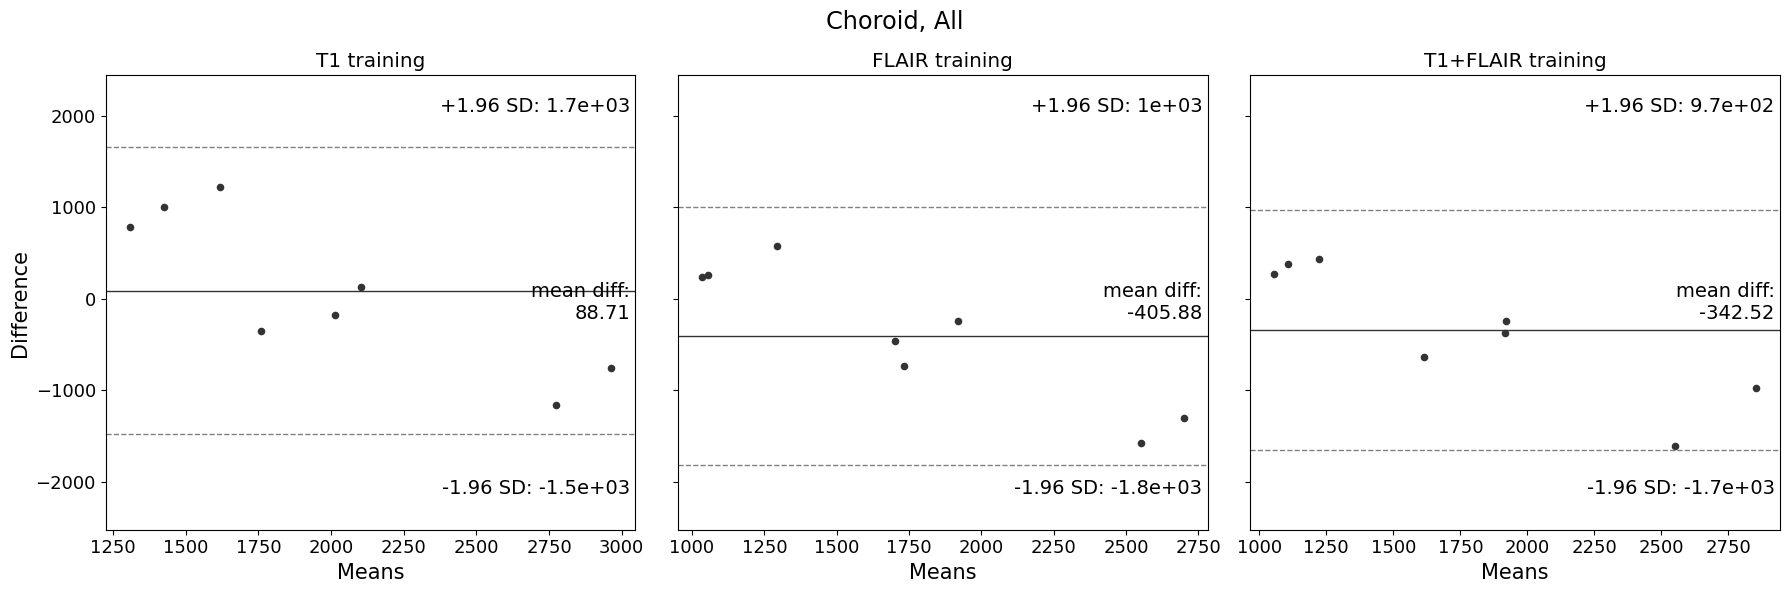

In [40]:
f = bland_altman_plots(ms_wocontrast, "choroid", "Choroid, All")

In [45]:
check_data = df[w_contrast(df)]
diff = check_data['cp_flair_vol'] - check_data['cp_man_vol']
stat, p = stats.wilcoxon(diff)
print(p)
print(diff.mean())

0.6720751523971558
-17.57000471999996


In [24]:
print("MS condition", "\n==============")
res = sm.OLS(df.loc[all_rows(df), 'cp_t1_diff'], 
             df.loc[all_rows(df), ['cp_t1_vol', 'cp_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1 model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[all_rows(df), 'cp_flair_diff'], 
             df.loc[all_rows(df), ['cp_flair_vol', 'cp_man_vol']].mean(axis=1),
             missing='drop').fit()
print("FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[all_rows(df), 'cp_t1_flair_diff'], 
             df.loc[all_rows(df), ['cp_t1.flair_vol', 'cp_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1.FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n\n")

MS condition 
T1 model
b=0.01, p=0.89 

FLAIR model
b=-0.08, p=0.09 

T1.FLAIR model
b=-0.06, p=0.13 




T1 outliers: 0
FLAIR outliers: 0
T1+FLAIR outliers: 0


/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument loo

T1 outliers: 0
FLAIR outliers: 0
T1+FLAIR outliers: 0


/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument loo

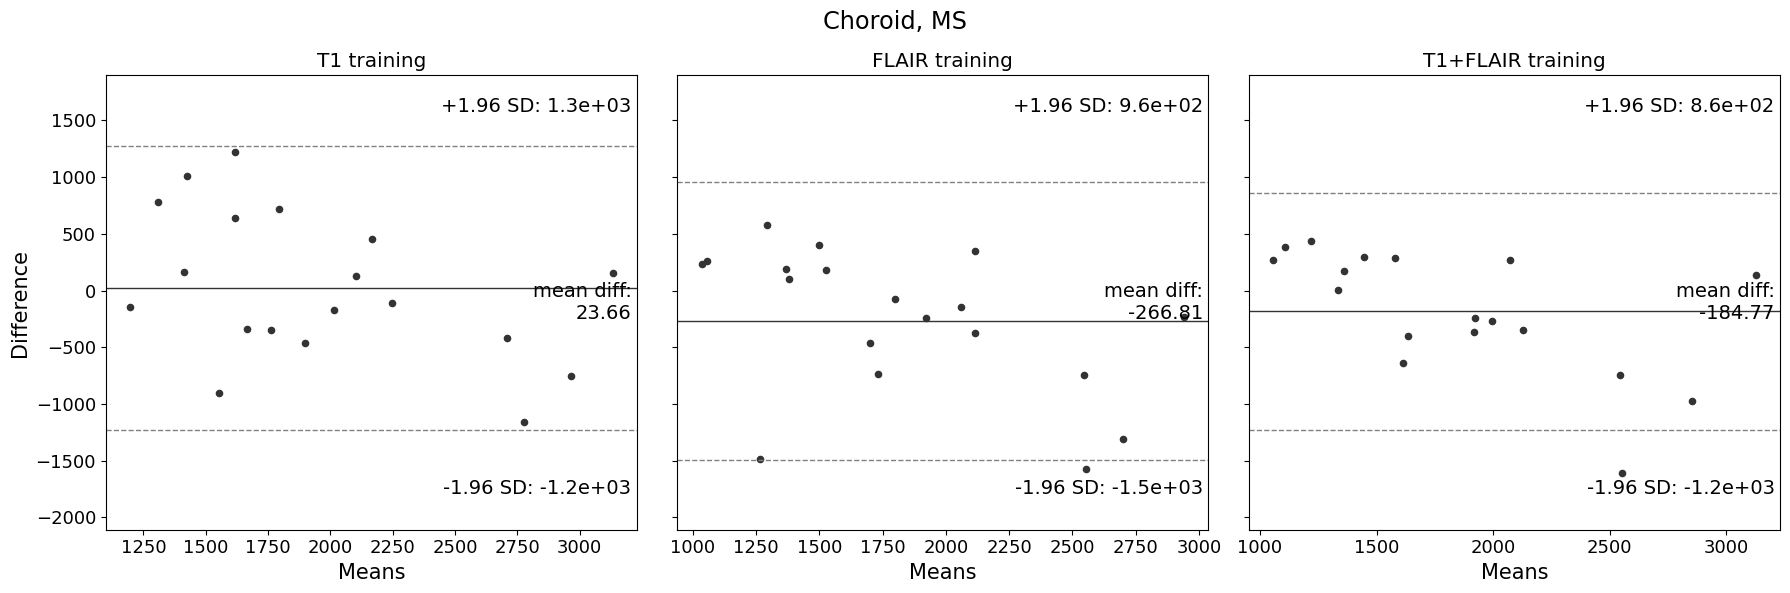

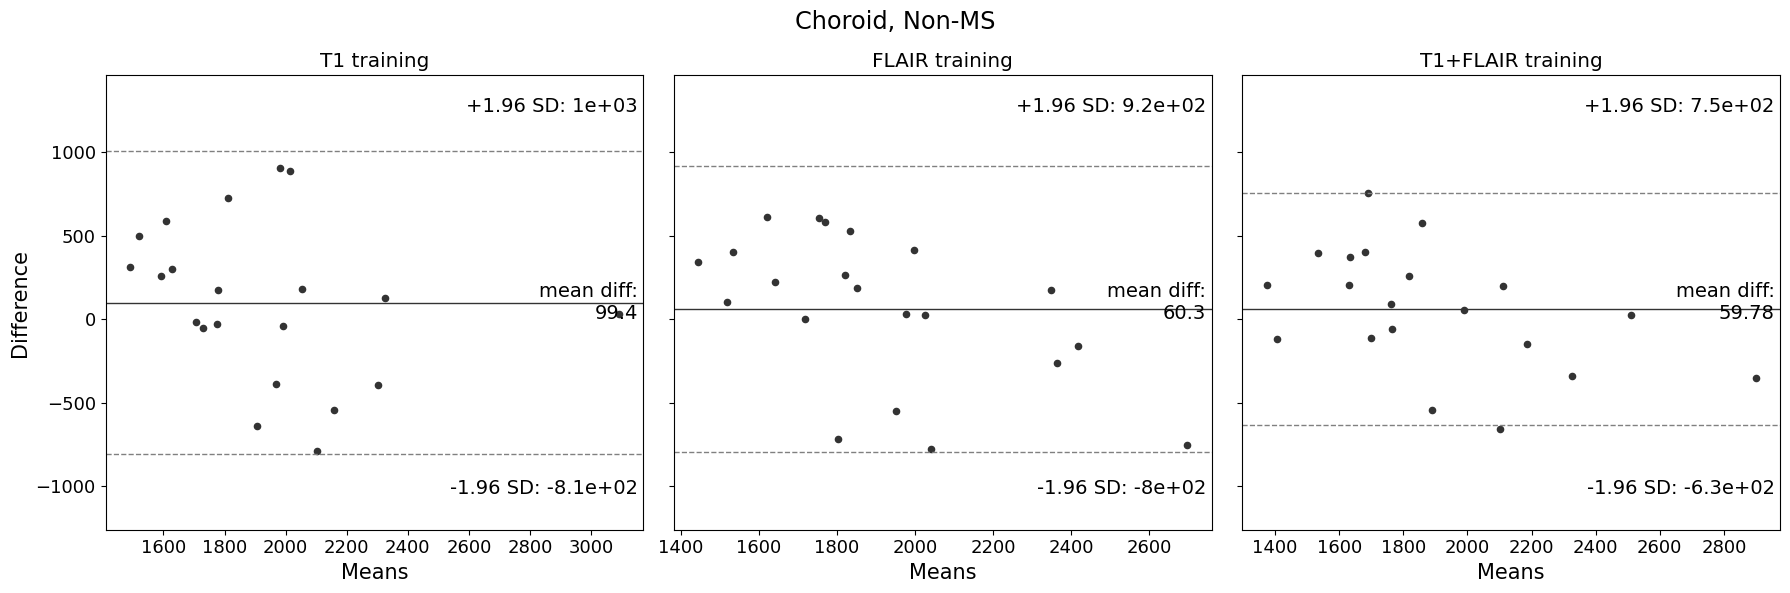

In [25]:
f = bland_altman_plots(ms_cond, "choroid", "Choroid, MS")
f = bland_altman_plots(notms_cond, "choroid", "Choroid, Non-MS")

In [26]:
print("MS condition", "\n==============")
res = sm.OLS(df.loc[ms_cond(df), 'cp_t1_diff'], 
             df.loc[ms_cond(df), ['cp_t1_vol', 'cp_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1 model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[ms_cond(df), 'cp_flair_diff'], 
             df.loc[ms_cond(df), ['cp_flair_vol', 'cp_man_vol']].mean(axis=1),
             missing='drop').fit()
print("FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[ms_cond(df), 'cp_t1_flair_diff'], 
             df.loc[ms_cond(df), ['cp_t1.flair_vol', 'cp_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1.FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n\n")


print("Non-MS condition", "\n==============")
res = sm.OLS(df.loc[notms_cond(df), 'cp_t1_diff'], 
             df.loc[notms_cond(df), ['cp_t1_vol', 'cp_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1 model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[notms_cond(df), 'cp_flair_diff'], 
             df.loc[notms_cond(df), ['cp_flair_vol', 'cp_man_vol']].mean(axis=1),
             missing='drop').fit()
print("FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[notms_cond(df), 'cp_t1_flair_diff'], 
             df.loc[notms_cond(df), ['cp_t1.flair_vol', 'cp_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1.FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]))

MS condition 
T1 model
b=-0.03, p=0.72 

FLAIR model
b=-0.18, p=0.02 

T1.FLAIR model
b=-0.14, p=0.04 


Non-MS condition 
T1 model
b=0.04, p=0.49 

FLAIR model
b=0.01, p=0.83 

T1.FLAIR model
b=0.01, p=0.75


T1 outliers: 0
FLAIR outliers: 0
T1+FLAIR outliers: 0
T1 outliers: 1


/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument loo

FLAIR outliers: 1
T1+FLAIR outliers: 1


/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument loo

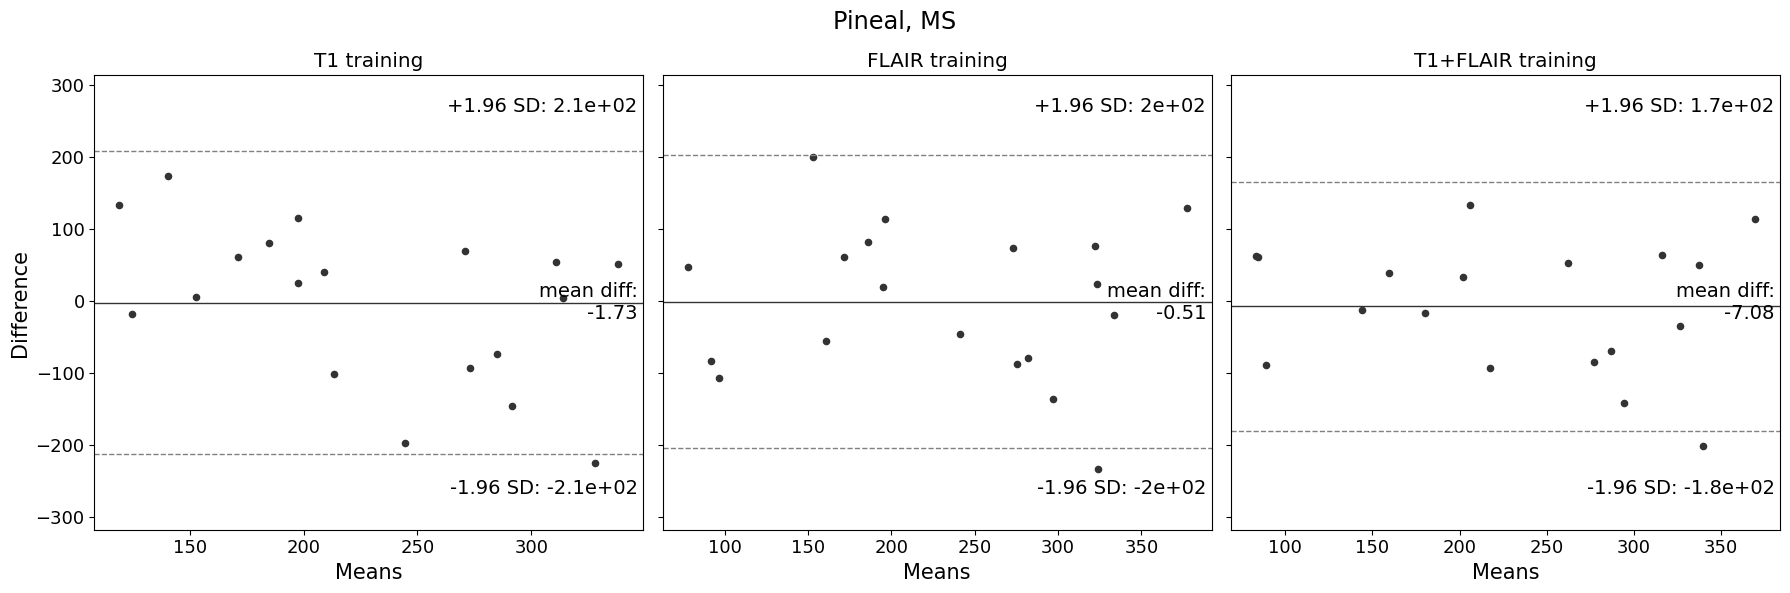

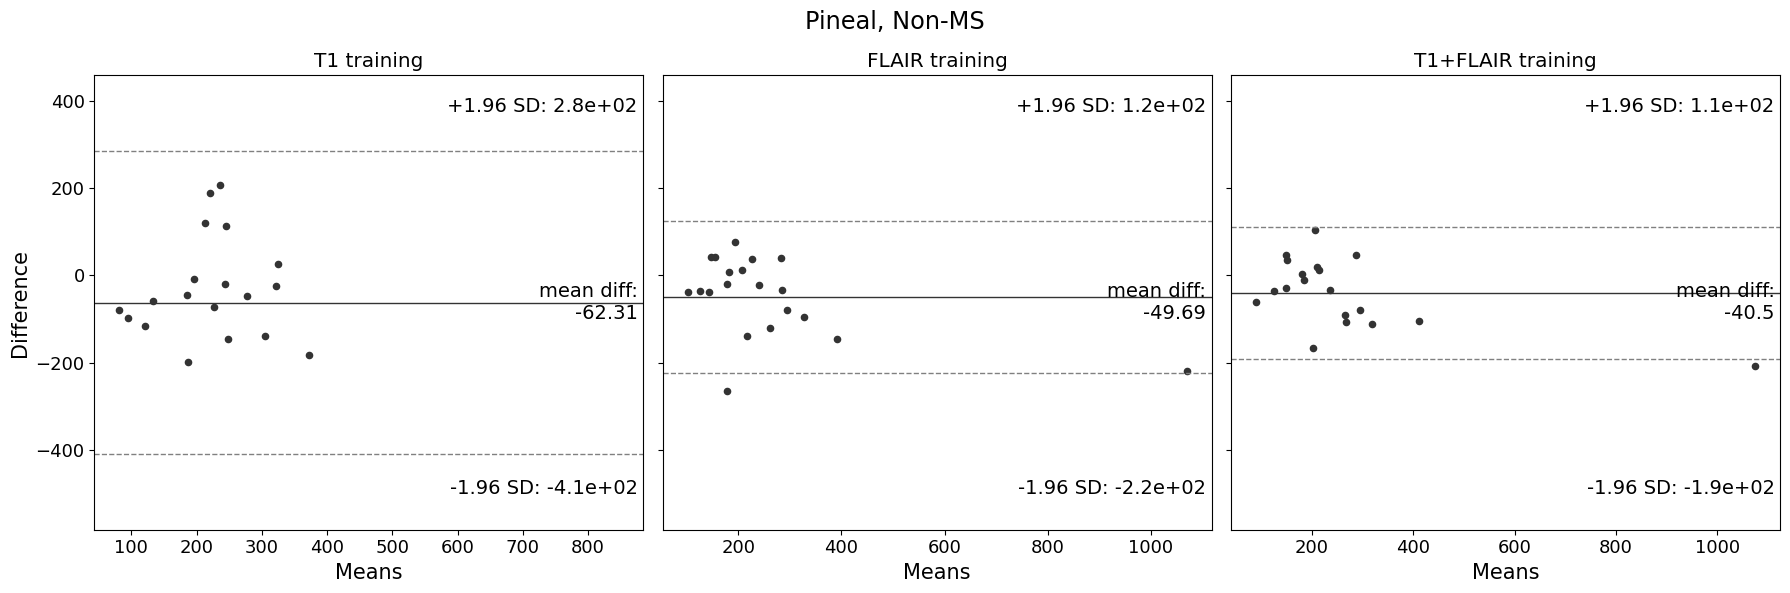

In [27]:
f = bland_altman_plots(ms_cond, "pineal", "Pineal, MS")
f = bland_altman_plots(notms_cond, "pineal", "Pineal, Non-MS")

In [28]:
print("MS condition", "\n==============")
res = sm.OLS(df.loc[ms_cond(df), 'pin_t1_diff'], 
             df.loc[ms_cond(df), ['pin_t1_vol', 'pin_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1 model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[ms_cond(df), 'pin_flair_diff'], 
             df.loc[ms_cond(df), ['pin_flair_vol', 'pin_man_vol']].mean(axis=1),
             missing='drop').fit()
print("FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[ms_cond(df), 'pin_t1_flair_diff'], 
             df.loc[ms_cond(df), ['pin_t1.flair_vol', 'pin_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1.FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n\n")


print("Non-MS condition", "\n==============")
res = sm.OLS(df.loc[notms_cond(df), 'pin_t1_diff'], 
             df.loc[notms_cond(df), ['pin_t1_vol', 'pin_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1 model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[notms_cond(df), 'pin_flair_diff'], 
             df.loc[notms_cond(df), ['pin_flair_vol', 'pin_man_vol']].mean(axis=1),
             missing='drop').fit()
print("FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[notms_cond(df), 'pin_t1_flair_diff'], 
             df.loc[notms_cond(df), ['pin_t1.flair_vol', 'pin_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1.FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]))

MS condition 
T1 model
b=-0.07, p=0.51 

FLAIR model
b=-0.02, p=0.88 

T1.FLAIR model
b=-0.05, p=0.59 


Non-MS condition 
T1 model
b=-0.95, p=0.00 

FLAIR model
b=-0.70, p=0.00 

T1.FLAIR model
b=-0.66, p=0.00


T1 outliers: 0
FLAIR outliers: 0
T1+FLAIR outliers: 0


/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument loo

T1 outliers: 1
FLAIR outliers: 0
T1+FLAIR outliers: 0


/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument loo

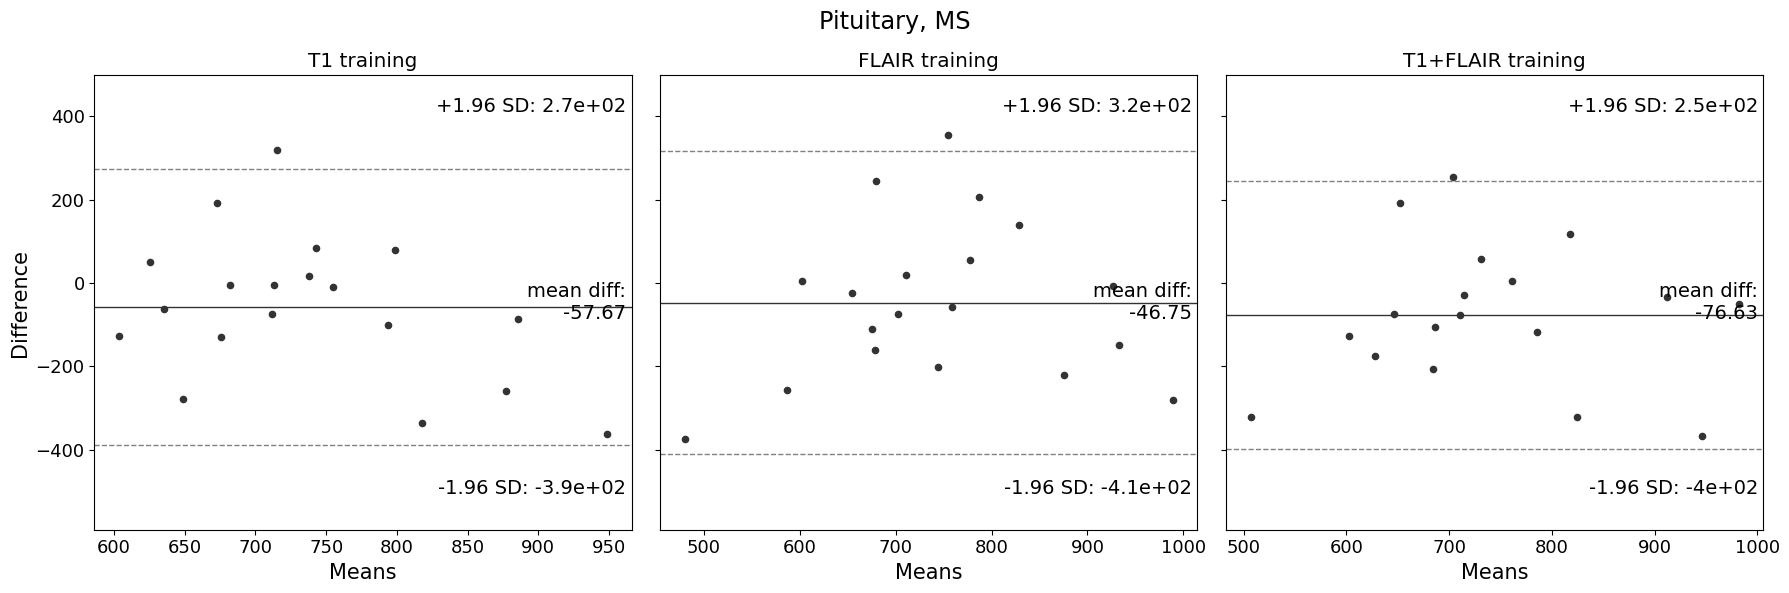

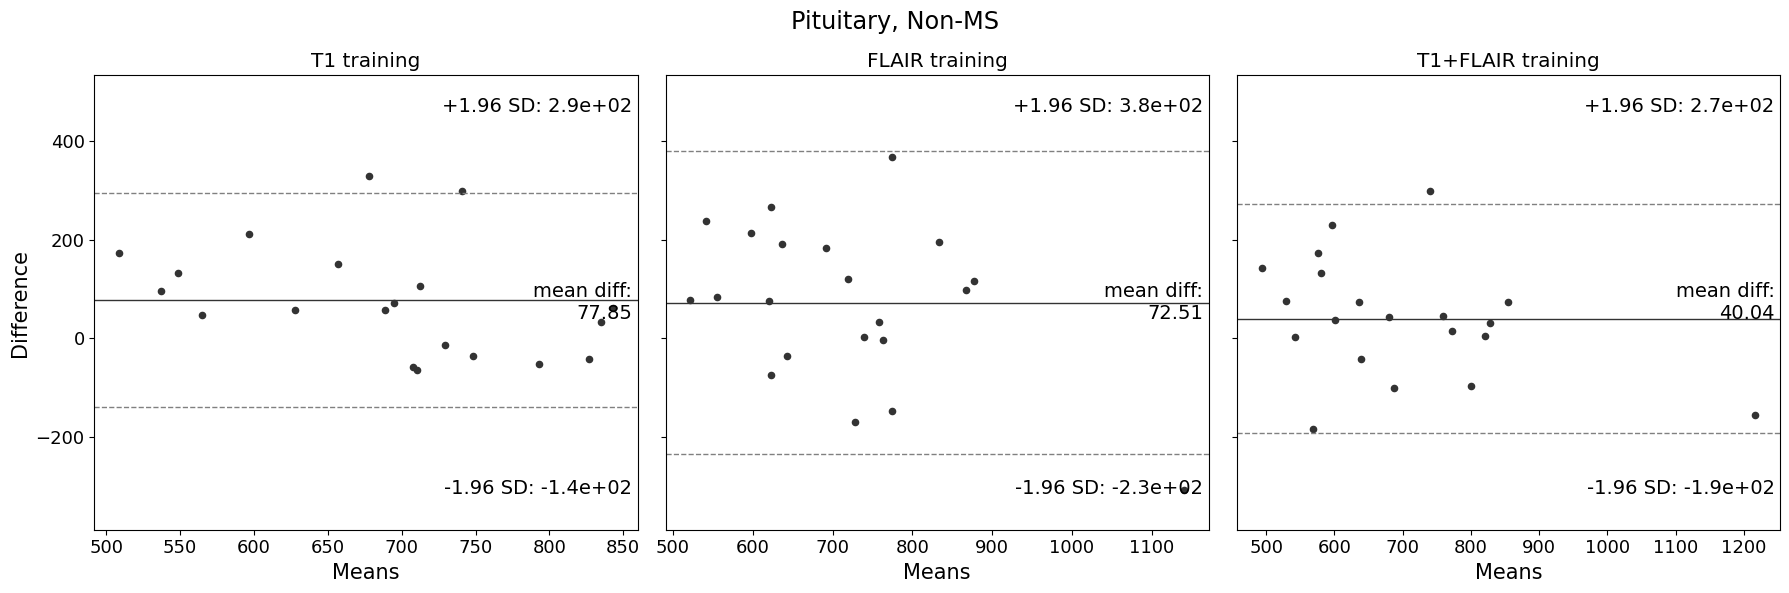

In [29]:
f = bland_altman_plots(ms_cond, "pituitary", "Pituitary, MS")
f = bland_altman_plots(notms_cond, "pituitary", "Pituitary, Non-MS")

In [30]:
print("MS condition", "\n==============")
res = sm.OLS(df.loc[ms_cond(df), 'pit_t1_diff'], 
             df.loc[ms_cond(df), ['pit_t1_vol', 'pit_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1 model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[ms_cond(df), 'pit_flair_diff'], 
             df.loc[ms_cond(df), ['pit_flair_vol', 'pit_man_vol']].mean(axis=1),
             missing='drop').fit()
print("FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[ms_cond(df), 'pit_t1_flair_diff'], 
             df.loc[ms_cond(df), ['pit_t1.flair_vol', 'pit_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1.FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n\n")


print("Non-MS condition", "\n==============")
res = sm.OLS(df.loc[notms_cond(df), 'pit_t1_diff'], 
             df.loc[notms_cond(df), ['pit_t1_vol', 'pit_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1 model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[notms_cond(df), 'pit_flair_diff'], 
             df.loc[notms_cond(df), ['pit_flair_vol', 'pit_man_vol']].mean(axis=1),
             missing='drop').fit()
print("FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[notms_cond(df), 'pit_t1_flair_diff'], 
             df.loc[notms_cond(df), ['pit_t1.flair_vol', 'pit_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1.FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]))

MS condition 
T1 model
b=-0.09, p=0.11 

FLAIR model
b=-0.06, p=0.34 

T1.FLAIR model
b=-0.10, p=0.07 


Non-MS condition 
T1 model
b=0.05, p=0.33 

FLAIR model
b=0.08, p=0.12 

T1.FLAIR model
b=0.04, p=0.31


Choroid outliers: 0
Pineal outliers: 1
Pituitary outliers: 0


/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(means, diffs, **scatter_kwds, c=markercolor) # Plot the means against the diffs.
/tmp/ipykernel_178847/4287344695.py:103: UserWarning: *c* argument loo

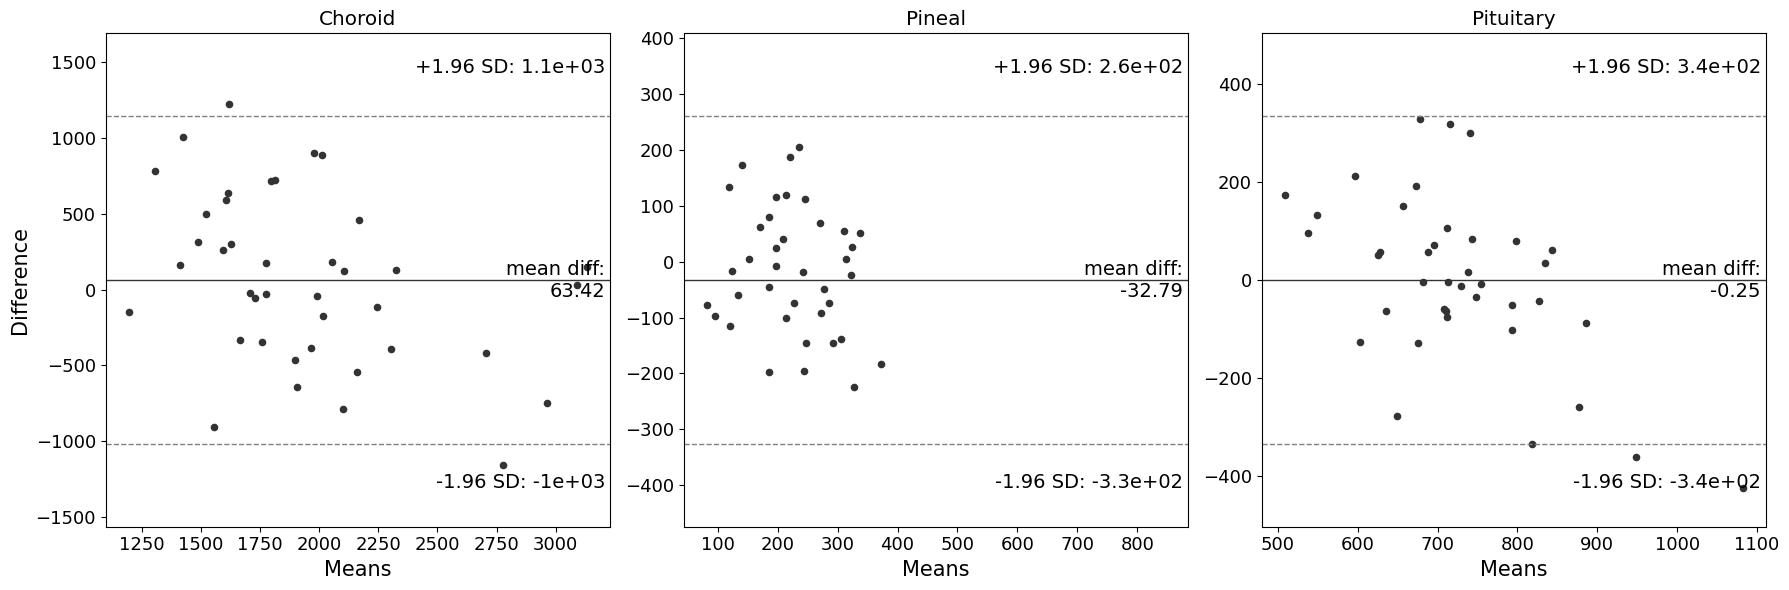

In [31]:
f, axes = plt.subplots(1, 3, figsize = (18,6))
f.patch.set_alpha(0)

lims = []

ax = axes[0]
struct = "choroid"
auto_col = f"{struct}_vol_auto"
man_col = f"{struct}_vol_man"
data = df_t1
print("Choroid outliers:", sum(zscores(data, struct) >= 3))
data = data[zscores(data, struct) < 3]
ax.set_title("Choroid", size="x-large")
mean_diff_plot(data[auto_col], data[man_col], ax=ax)
lims.append(ax.get_ylim())

ax = axes[1]
struct = "pineal"
auto_col = f"{struct}_vol_auto"
man_col = f"{struct}_vol_man"
print("Pineal outliers:", sum(zscores(data, struct) >= 3))
data = data[zscores(data, struct) < 3]
ax.set_title("Pineal", size="x-large")
mean_diff_plot(data[auto_col], data[man_col], ax=ax)
ax.set_ylabel("")
lims.append(ax.get_ylim())

ax = axes[2]
struct = "pituitary"
auto_col = f"{struct}_vol_auto"
man_col = f"{struct}_vol_man"
print("Pituitary outliers:", sum(zscores(data, struct) >= 3))
ax.set_title("Pituitary", size="x-large")
mean_diff_plot(data[auto_col], data[man_col], ax=ax)
ax.set_ylabel("")
lims.append(ax.get_ylim())

plt.tight_layout()

In [32]:
t, p = stats.wilcoxon(df['cp_t1_diff'])
print("Choroid: {:0.2f}".format(p))

t, p = stats.wilcoxon(df['pin_t1_diff'])
print("Pineal: {:0.2f}".format(p))

t, p = stats.wilcoxon(df['pit_t1_diff'])
print("Pituitary: {:0.2f}".format(p))

Choroid: 0.51
Pineal: 0.19
Pituitary: 0.74


In [33]:
res = sm.OLS(df.loc[:, 'cp_t1_diff'], 
             df.loc[:, ['cp_t1_vol', 'cp_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1 model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[:, 'pin_t1_diff'], 
             df.loc[:, ['pin_t1_vol', 'pit_man_vol']].mean(axis=1),
             missing='drop').fit()
print("FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n")

res = sm.OLS(df.loc[:, 'pit_t1_diff'], 
             df.loc[:, ['pit_t1_vol', 'pit_man_vol']].mean(axis=1),
             missing='drop').fit()
print("T1.FLAIR model")
print("b={:0.2f}, p={:0.2f}".format(res.params.iloc[0], res.pvalues.iloc[0]), "\n\n")

T1 model
b=0.01, p=0.89 

FLAIR model
b=-0.12, p=0.29 

T1.FLAIR model
b=-0.02, p=0.62 




## Compare T1 and FLAIR Inference

In [38]:
df.loc[:, 'cp_flair_t1_diff'] = df['cp_flair_vol'] - df['cp_t1_vol']

(array([1., 1., 2., 2., 0., 0., 2., 0., 1., 2.]),
 array([-822.27417  , -751.8228272, -681.3714844, -610.9201416,
        -540.4687988, -470.017456 , -399.5661132, -329.1147704,
        -258.6634276, -188.2120848, -117.760742 ]),
 <BarContainer object of 10 artists>)

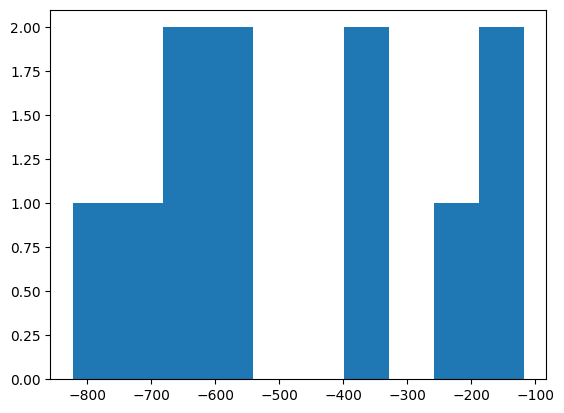

In [44]:
plt.hist(df.loc[df['flair_contrast']=="WITHOUT", 'cp_flair_t1_diff'])

In [47]:
sum(df['flair_contrast']=="WITHOUT")

11

<BarContainer object of 2 artists>

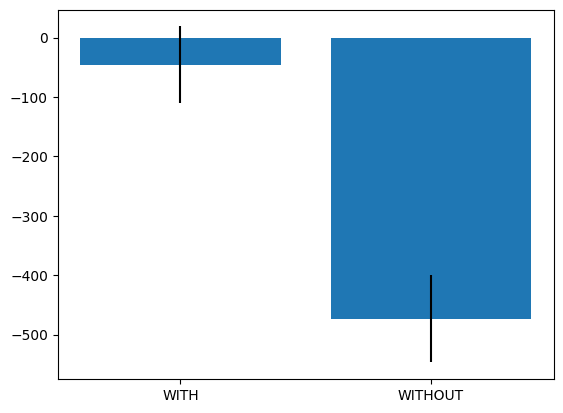

In [39]:
plt.bar(["WITH", "WITHOUT"], [
    df.loc[df['flair_contrast'] == "WITH", 'cp_flair_t1_diff'].mean(),
    df.loc[df['flair_contrast'] == "WITHOUT", 'cp_flair_t1_diff'].mean()
    ], yerr=[
        df.loc[df['flair_contrast'] == "WITH", 'cp_flair_t1_diff'].sem(),
        df.loc[df['flair_contrast'] == "WITHOUT", 'cp_flair_t1_diff'].sem()
    ]
)

## Look at Images

In [34]:
from mri_data import file_manager as fm

drive_root = fm.get_drive_root()
smbshare = Path("/media/smbshare")

ubuntu_twd = Path("/home/srs-9/Projects/ms_mri/training_work_dirs")
data_twd = Path("/mnt/h/srs-9/training_work_dirs")
# data_twd = ubuntu_twd

def fix_path(path, drive_root, other_root):
    return drive_root / Path(path).relative_to(other_root)

In [35]:
cmds = df_flair[['subject_id', 'ms_type', 'dz_type2', 'flair_contrast']]
for i, row in cmds.iterrows():
    man_label = fix_path(df_flair.at[i, 'manual_label'], drive_root, smbshare)
    flair_label = fix_path(df_flair.at[i, 'auto_label'], data_twd, ubuntu_twd)
    t1_label = fix_path(df_t1.at[i, 'auto_label'], data_twd, ubuntu_twd)
    t1_flair_label = fix_path(df_t1_flair.at[i, 'auto_label'], data_twd, ubuntu_twd)
    scan_folder = fix_path(df_flair.at[i, 'scan_folder'], drive_root, smbshare)

    scans = [scan_folder / "t1.nii.gz", scan_folder / "flair.nii.gz"]
    labels = [man_label, flair_label, t1_label]
    cmds.loc[i, ['itksnap_cmd']] = mri_utils.open_itksnap_workspace_cmd(scans, labels, win=False)
    cmds.loc[i, ['fsleyes_cmd']] = mri_utils.fsleyes_cmd(scans, [flair_label, t1_label], [man_label])

cmds = cmds.set_index('subject_id')

In [30]:
import pyperclip
import subprocess

subid = 1019
fsleyes_cmd = cmds.loc[subid, "fsleyes_cmd"]
itksnap_cmd = cmds.loc[subid, "itksnap_cmd"]

subprocess.Popen(itksnap_cmd.split(" "))
subprocess.Popen(fsleyes_cmd.split(" "))

<Popen: returncode: None args: ['fsleyes', '/mnt/h/3Tpioneer_bids/sub-ms1019...>